### DfT charging device statistics explore

In [269]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm

tqdm.pandas()

import requests

from matplotlib import pyplot as plt

Importing and wrangling the data. We download the sheet from the link, then remove unnecessary bumpf on the spreadsheet. 

In [259]:
df_01a = pd.read_excel('https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1048354/electric-vehicle-charging-device-statistics-january-2022.ods', engine='odf', sheet_name='EVCD_01a')
df_01b = pd.read_excel('https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1048354/electric-vehicle-charging-device-statistics-january-2022.ods', engine='odf', sheet_name='EVCD_01b')
df_02 = pd.read_excel('https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1048354/electric-vehicle-charging-device-statistics-january-2022.ods', engine='odf', sheet_name='EVCD_02')

Import tables 01a and 01b:

In [260]:
# This function cleans up the first two sheets, the following function cleans up the last sheet

def df_cleaner(df):
    new_cols = df.iloc[5].tolist()
    new_cols[0] = 'lacd'
    new_cols[1] = 'lanm'
    new_cols = [str(x) for x in new_cols]
    new_cols = [x.replace(' 00:00:00', '') for x in new_cols]

    df.columns = new_cols
    df.drop(columns = ['nan'], inplace=True)
    df = df.iloc[7:]
    df = df.iloc[:429]
    return df

df_01a = df_cleaner(df_01a)
df_01b = df_cleaner(df_01b)

In [277]:
# Replace '-' with '0' and then convert all numbers to numeric data types.

for col in tqdm(df_01a.columns[2:]):
    df_01a[col] = df_01a[col].progress_apply(lambda x: str(x).replace('-', '0'))
    df_01a[col] = pd.to_numeric(df_01a[col])

100%|██████████| 429/429 [00:00<00:00, 352055.65it/s]

100%|██████████| 429/429 [00:00<00:00, 486970.61it/s]

100%|██████████| 429/429 [00:00<00:00, 447045.07it/s]

100%|██████████| 429/429 [00:00<00:00, 605232.57it/s]

100%|██████████| 429/429 [00:00<00:00, 706183.84it/s]

100%|██████████| 429/429 [00:00<00:00, 700683.96it/s]

100%|██████████| 429/429 [00:00<00:00, 575794.05it/s]

100%|██████████| 429/429 [00:00<00:00, 657899.97it/s]

100%|██████████| 429/429 [00:00<00:00, 757942.89it/s]

100%|██████████| 10/10 [00:00<00:00, 252.93it/s]


Import table 02

In [261]:
new_cols = df_02.iloc[5]
df_02.columns = new_cols
df_02 = df_02.iloc[6:35, :4]
df_02['Year'].fillna(method = 'ffill', inplace=True)
df_02.reset_index(inplace=True, drop=True)
df_02 = df_02.reindex(index=df_02.index[::-1])
df_02['Date'] = df_02.apply(lambda row: str(row['Year'])+'-'+row['Month'], axis=1)
df_02['Date'] = pd.to_datetime(df_02.Date)
# df_02.set_index('Date', inplace=True)
df_02.drop(columns=['Year', 'Month'], inplace=True)

#### The number of rapid chargers

`df_02` contains the number of rapid chargers installed every quarter. 

In [262]:
# We get the rate of installations in each quarter by first calculating the additional chargers installed in between each statistical release. 
# Sorting by date, we get the latest statistical release at the bottom, and the earliest statistical release (Q2 2015) at the top. 

df_02_rate = df_02.copy()
df_02_rate['time_diff'] = df_02_rate.sort_values('Date', ascending=True)['Date'].diff()
df_02_rate['total_d_diff'] = df_02_rate.sort_values('Date', ascending=True)['Total Devices'].diff()
df_02_rate['rapids_diff'] = df_02_rate.sort_values('Date', ascending=True)['Rapid Devices'].diff()
df_02_rate.dropna(inplace=True)

df_02_rate.head()

5,Total Devices,Rapid Devices,Date,time_diff,total_d_diff,rapids_diff
28,28375,5156,2022-01-01,92 days,2448,233
27,25927,4923,2021-10-01,92 days,1553,372
26,24374,4551,2021-07-01,91 days,1584,292
25,22790,4259,2021-04-01,90 days,2015,379
24,20775,3880,2021-01-01,92 days,1288,350


In [263]:
# We calculate the chargers installed per day:

# Convert the time delta to a number
df_02_rate['num_days'] = df_02_rate.time_diff.dt.days

df_02_rate['total_daily'] = df_02_rate.apply(lambda row: row['total_d_diff'] / row['num_days'], axis=1)
df_02_rate['rapids_daily'] = df_02_rate.apply(lambda row: row['rapids_diff'] / row['num_days'], axis=1)

In [264]:
df_02_rate.set_index('Date', inplace=True)

In [265]:
df_02_rate.head()

5,Total Devices,Rapid Devices,time_diff,total_d_diff,rapids_diff,num_days,total_daily,rapids_daily
Date,,,,,,,,
2022-01-01,28375,5156,92 days,2448,233,92,26.608696,2.532609
2021-10-01,25927,4923,92 days,1553,372,92,16.880435,4.043478
2021-07-01,24374,4551,91 days,1584,292,91,17.406593,3.208791
2021-04-01,22790,4259,90 days,2015,379,90,22.388889,4.211111
2021-01-01,20775,3880,92 days,1288,350,92,14.000000,3.804348


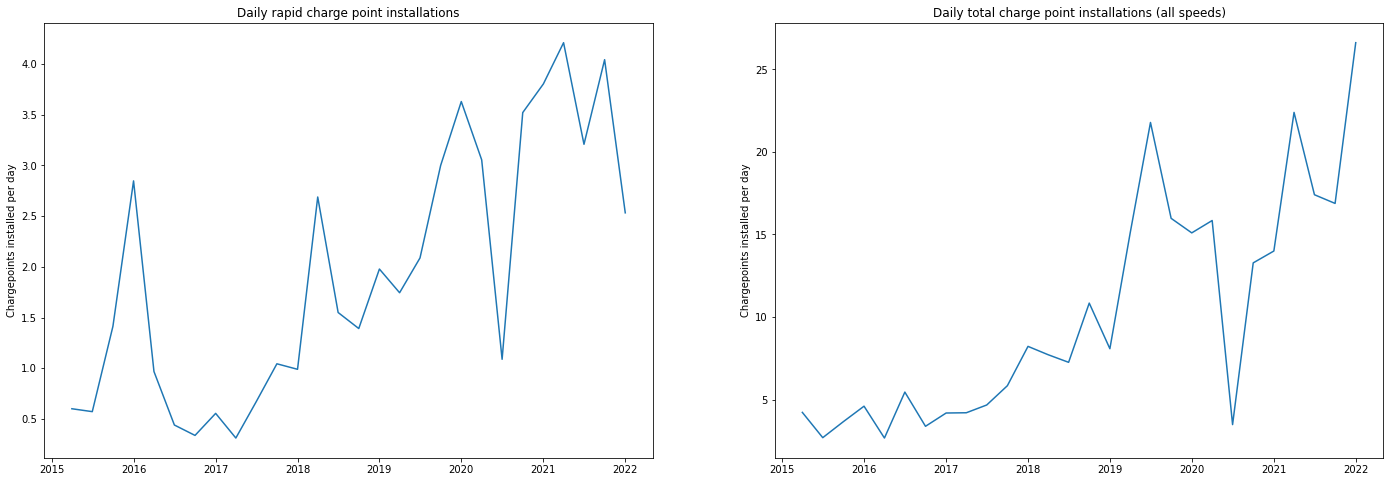

In [266]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(24, 8))

ax1.plot(df_02_rate.rapids_daily)
ax1.set_title('Daily rapid charge point installations')
ax1.set_ylabel('Chargepoints installed per day')

ax2.plot(df_02_rate.total_daily)
ax2.set_title('Daily total charge point installations (all speeds)')
ax2.set_ylabel('Chargepoints installed per day')

plt.show()

### Investigating the places with the most chargepoints

Obtain a list of all local authorities first:


In [311]:
df_lad = pd.read_csv('Local_Authority_District_to_Region_(April_2021)_Lookup_in_England.csv')
lad_codes = df_lad.LAD21CD.tolist()
region_codes = df_lad.RGN21CD.tolist()

In [300]:
# Filter out any non-LAD areas, e.g. Regions and Nations
df_01a_lad = df_01a[df_01a.lacd.isin(lad_codes)]
df_01a_lad['Q4_2021'] = df_01a_lad.apply(lambda row: row['2022-01-01'] - row['2021-10-01'], axis=1)
df_01a_lad['2021'] = df_01a_lad.apply(lambda row: row['2022-01-01'] - row['2021-01-01'], axis=1)

<ipython-input-300-d2bc50b37a6a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_01a_lad['Q4_2021'] = df_01a_lad.apply(lambda row: row['2022-01-01'] - row['2021-10-01'], axis=1)
<ipython-input-300-d2bc50b37a6a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_01a_lad['2021'] = df_01a_lad.apply(lambda row: row['2022-01-01'] - row['2021-01-01'], axis=1)


In [301]:
# The largest quarterly increase in chargepoints happened in these LADs

df_01a_lad.sort_values('Q4_2021', ascending=False).head(20)

,lacd,lanm,2022-01-01,2021-10-01,2021-07-01,2021-04-01,2021-01-01,2020-10-01,2020-07-01,2020-04-01,2020-01-01,2019-10-01,Q4_2021,2021
247,E09000005,Brent,485,237,203,236,233,211,211,209,206,207,248,252
256,E09000018,Hounslow,419,282,268,266,261,256,262,258,226,227,137,158
235,E09000020,Kensington and Chelsea,658,547,547,515,420,309,309,306,277,163,111,238
257,E09000021,Kingston upon Thames,178,96,51,52,52,31,29,28,28,27,82,126
261,E09000029,Sutton,128,51,55,55,52,49,48,49,47,46,77,76
245,E09000003,Barnet,287,210,197,175,139,139,136,137,135,68,77,148
258,E09000024,Merton,263,199,197,173,168,157,154,153,120,118,64,95
231,E09000012,Hackney,197,139,136,135,134,130,128,128,127,126,58,63
238,E09000025,Newham,210,153,120,120,100,102,97,95,95,83,57,110
242,E09000033,Westminster,1147,1095,1059,1021,646,556,575,570,527,485,52,501


In [302]:
# The largest yearly increase in chargepoints happened in these LADs

df_01a_lad.sort_values('2021', ascending=False).head(20)

,lacd,lanm,2022-01-01,2021-10-01,2021-07-01,2021-04-01,2021-01-01,2020-10-01,2020-07-01,2020-04-01,2020-01-01,2019-10-01,Q4_2021,2021
242,E09000033,Westminster,1147,1095,1059,1021,646,556,575,570,527,485,52,501
247,E09000005,Brent,485,237,203,236,233,211,211,209,206,207,248,252
235,E09000020,Kensington and Chelsea,658,547,547,515,420,309,309,306,277,163,111,238
163,E08000026,Coventry,485,481,456,296,260,256,203,184,170,156,4,225
232,E09000013,Hammersmith and Fulham,598,580,554,528,386,374,316,301,291,274,18,212
239,E09000028,Southwark,438,390,357,328,267,249,199,195,191,154,48,171
256,E09000018,Hounslow,419,282,268,266,261,256,262,258,226,227,137,158
245,E09000003,Barnet,287,210,197,175,139,139,136,137,135,68,77,148
240,E09000030,Tower Hamlets,214,190,182,167,78,79,79,79,79,78,24,136
257,E09000021,Kingston upon Thames,178,96,51,52,52,31,29,28,28,27,82,126


In [306]:
# Calculate increase as a percentage of existing chargepoints

df_01a_lad['quart_perc_inc'] = df_01a_lad.apply(lambda row: row['Q4_2021']/row['2021-10-01'] if row['2021-10-01'] > 0 else 0, axis=1)
df_01a_lad['year_perc_inc'] = df_01a_lad.apply(lambda row: row['2021']/row['2021-01-01'] if row['2021-01-01'] > 0 else 0, axis=1)

<ipython-input-306-e2b6ee29ff74>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_01a_lad['quart_perc_inc'] = df_01a_lad.apply(lambda row: row['Q4_2021']/row['2021-10-01'] if row['2021-10-01'] > 0 else 0, axis=1)
<ipython-input-306-e2b6ee29ff74>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_01a_lad['year_perc_inc'] = df_01a_lad.apply(lambda row: row['2021']/row['2021-01-01'] if row['2021-01-01'] > 0 else 0, axis=1)


In [307]:

df_01a_lad.sort_values('quart_perc_inc', ascending=False).head(20)

,lacd,lanm,2022-01-01,2021-10-01,2021-07-01,2021-04-01,2021-01-01,2020-10-01,2020-07-01,2020-04-01,2020-01-01,2019-10-01,Q4_2021,2021,quart_perc_inc,year_perc_inc
267,E06000035,Medway,44,17,18,18,16,16,16,15,14,15,27,28,1.588235,1.750000
261,E09000029,Sutton,128,51,55,55,52,49,48,49,47,46,77,76,1.509804,1.461538
247,E09000005,Brent,485,237,203,236,233,211,211,209,206,207,248,252,1.046414,1.081545
257,E09000021,Kingston upon Thames,178,96,51,52,52,31,29,28,28,27,82,126,0.854167,2.423077
203,E07000095,Broxbourne,32,18,10,7,7,7,6,7,6,6,14,25,0.777778,3.571429
279,E07000062,Hastings,25,15,14,13,14,11,8,8,8,7,10,11,0.666667,0.785714
33,E07000027,Barrow-in-Furness,15,9,8,7,3,3,2,2,0,0,6,12,0.666667,4.000000
209,E07000243,Stevenage,15,9,11,11,11,9,6,6,6,6,6,4,0.666667,0.363636
281,E07000064,Rother,21,13,12,10,10,10,9,9,9,9,8,11,0.615385,1.100000
148,E07000193,East Staffordshire,32,20,21,20,19,17,15,15,14,12,12,13,0.600000,0.684211


In [309]:
df_01a_lad.sort_values('year_perc_inc', ascending=False).head(20)

,lacd,lanm,2022-01-01,2021-10-01,2021-07-01,2021-04-01,2021-01-01,2020-10-01,2020-07-01,2020-04-01,2020-01-01,2019-10-01,Q4_2021,2021,quart_perc_inc,year_perc_inc
33,E07000027,Barrow-in-Furness,15,9,8,7,3,3,2,2,0,0,6,12,0.666667,4.000000
116,E07000135,Oadby and Wigston,25,25,25,10,5,5,3,3,1,1,0,20,0.000000,4.000000
203,E07000095,Broxbourne,32,18,10,7,7,7,6,7,6,6,14,25,0.777778,3.571429
257,E09000021,Kingston upon Thames,178,96,51,52,52,31,29,28,28,27,82,126,0.854167,2.423077
299,E07000108,Dover,36,31,14,11,11,11,11,10,9,9,5,25,0.161290,2.272727
253,E09000015,Harrow,50,49,49,26,16,15,16,15,15,14,1,34,0.020408,2.125000
251,E09000010,Enfield,163,125,105,77,54,37,39,39,38,33,38,109,0.304000,2.018519
156,E07000218,North Warwickshire,39,33,28,28,13,12,12,12,10,8,6,26,0.181818,2.000000
214,E07000143,Breckland,50,41,33,28,18,18,16,16,16,15,9,32,0.219512,1.777778
158,E07000220,Rugby,58,53,45,21,21,18,15,15,4,3,5,37,0.094340,1.761905


### Regions

In [336]:
# Filter out any non-Region areas, e.g. LADs and Nations
df_01a_rgn = df_01a[df_01a.lacd.isin(region_codes)]
df_01a_rgn['Q4_2021'] = df_01a_rgn.apply(lambda row: row['2022-01-01'] - row['2021-10-01'], axis=1)
df_01a_rgn['2021'] = df_01a_rgn.apply(lambda row: row['2022-01-01'] - row['2021-01-01'], axis=1)

<ipython-input-336-abc5470fe04a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_01a_rgn['Q4_2021'] = df_01a_rgn.apply(lambda row: row['2022-01-01'] - row['2021-10-01'], axis=1)
<ipython-input-336-abc5470fe04a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_01a_rgn['2021'] = df_01a_rgn.apply(lambda row: row['2022-01-01'] - row['2021-01-01'], axis=1)


In [337]:
# Calculate increase as a percentage of existing chargepoints

df_01a_rgn['quart_perc_inc'] = df_01a_rgn.apply(lambda row: row['Q4_2021']/row['2021-10-01'] if row['2021-10-01'] > 0 else 0, axis=1)
df_01a_rgn['year_perc_inc'] = df_01a_rgn.apply(lambda row: row['2021']/row['2021-01-01'] if row['2021-01-01'] > 0 else 0, axis=1)

<ipython-input-337-f118698dc66d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_01a_rgn['quart_perc_inc'] = df_01a_rgn.apply(lambda row: row['Q4_2021']/row['2021-10-01'] if row['2021-10-01'] > 0 else 0, axis=1)
<ipython-input-337-f118698dc66d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_01a_rgn['year_perc_inc'] = df_01a_rgn.apply(lambda row: row['2021']/row['2021-01-01'] if row['2021-01-01'] > 0 else 0, axis=1)


In [338]:
df_01a_rgn_wd = df_01a_rgn.copy()

In [339]:
df_01a_rgn_wd.drop(columns=['lacd', 'quart_perc_inc', 'year_perc_inc', 'Q4_2021', '2021'], inplace=True)

In [342]:
df_01a_rgn_wd = df_01a_rgn_wd.T

In [349]:
df_01a_rgn_wd.columns = df_01a_rgn_wd.iloc[0]
df_01a_rgn_wd = df_01a_rgn_wd.iloc[1:]

In [352]:
df_01a_rgn_wd.index = pd.to_datetime(df_01a_rgn_wd.index)

Text(0.5, 0, 'Quarter')

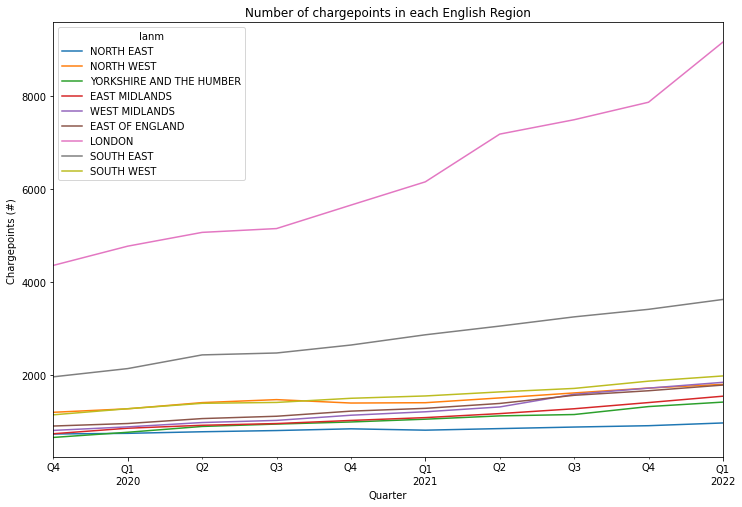

In [359]:
fig, ax = plt.subplots(figsize=(12, 8))

df_01a_rgn_wd.plot(ax=ax)
ax.set_title('Number of chargepoints in each English Region')
ax.set_ylabel('Chargepoints (#)')
ax.set_xlabel('Quarter')